In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the dataset
# Replace 'your_data.csv' with your actual file path
data = pd.read_excel('/kaggle/input/randomforestregressor/Data for Item Proposal_Regional-1.xlsx', sheet_name="Raw Data")

data.columns=data.columns.str.replace(' ', "_")

# Preprocess: Handle 'Month' column if it's datetime
if pd.api.types.is_datetime64_any_dtype(data['Month']):
    data['Month_Number'] = pd.to_datetime(data['Month']).dt.month
    data['Year'] = pd.to_datetime(data['Month']).dt.year
    data = data.drop('Month', axis=1)
else:
    print("Month is not datetime, treating as categorical")

# Preprocess: Encode categorical variables
data = pd.get_dummies(data, columns=['Zone_Name', 'Depot', 'Category'])

# Features and target
X = data.drop(['Net_Sales', 'Item_Name', 'Item_Code'], axis=1)
y = data['Net_Sales']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical Features: {categorical_cols}")
print(f"Numerical Features: {numerical_cols}")

# Step 3: Encode Categorical Variables
# Using Target Encoding for better performance with high-cardinality categories
encoder = ce.TargetEncoder(cols=categorical_cols)
X_encoded = encoder.fit_transform(X, y)

# Verify feature names
print("Feature names:", X.columns.tolist())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Categorical Features: []
Numerical Features: ['Unit_Price', 'Sales', 'Sales_Qty', 'Net_Discount', 'Month_Number', 'Year']
Feature names: ['Unit_Price', 'Sales', 'Sales_Qty', 'Net_Discount', 'Month_Number', 'Year', 'Zone_Name_Barishal', 'Zone_Name_Bogura', 'Zone_Name_Chattogram', 'Zone_Name_Cumilla', 'Zone_Name_Dhaka City', 'Zone_Name_Dinajpur', 'Zone_Name_Gazipur', 'Zone_Name_Jashore', 'Zone_Name_Khulna', 'Zone_Name_Kushtia', 'Zone_Name_Mymensingh', 'Zone_Name_Rajshahi', 'Zone_Name_Rangpur', 'Zone_Name_Sylhet', 'Depot_Depot-1', 'Depot_Depot-2', 'Depot_Depot-3', 'Depot_Depot-4', 'Depot_Depot-5', 'Depot_Depot-6', 'Depot_Depot-7', 'Category_Bicycle Tube', 'Category_Bicycle Tyre', 'Category_Red Tube', 'Category_Rickshaw Tube', 'Category_Rickshaw Tyre']


In [3]:
# Step 5: Model Training
print("\nTraining Random Forest Regressor...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)



Training Random Forest Regressor...


RandomForestRegressor(n_jobs=-1, random_state=42)

In [8]:
# Step 6: Predictions
predictions = model.predict(X_test)

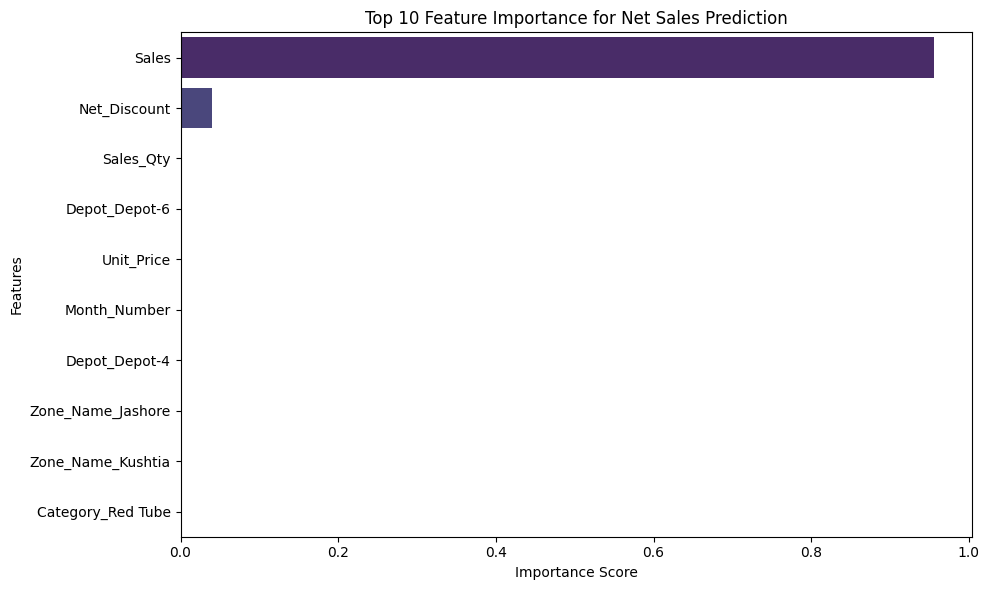

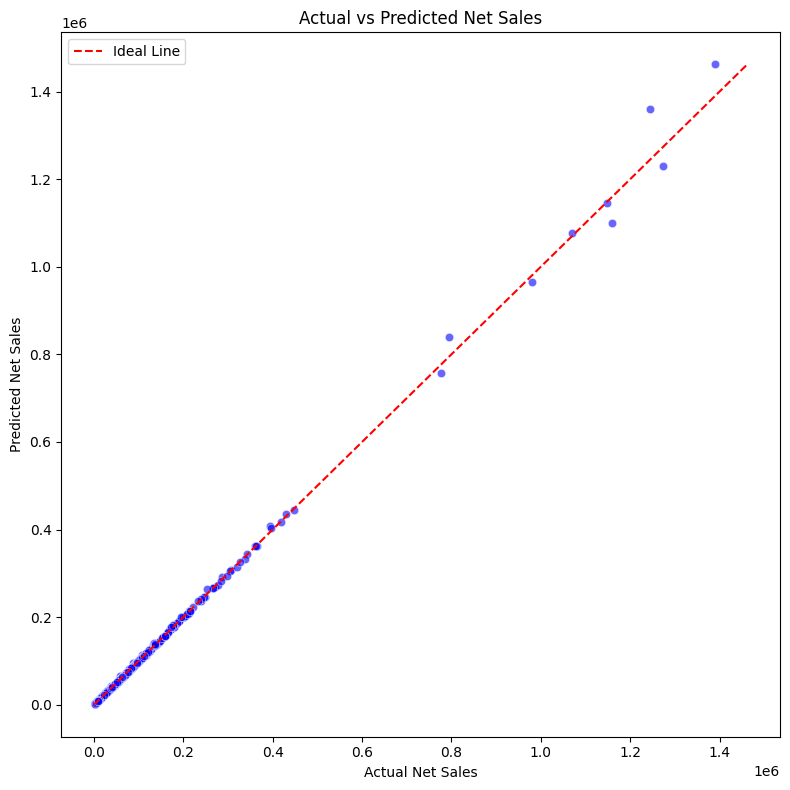

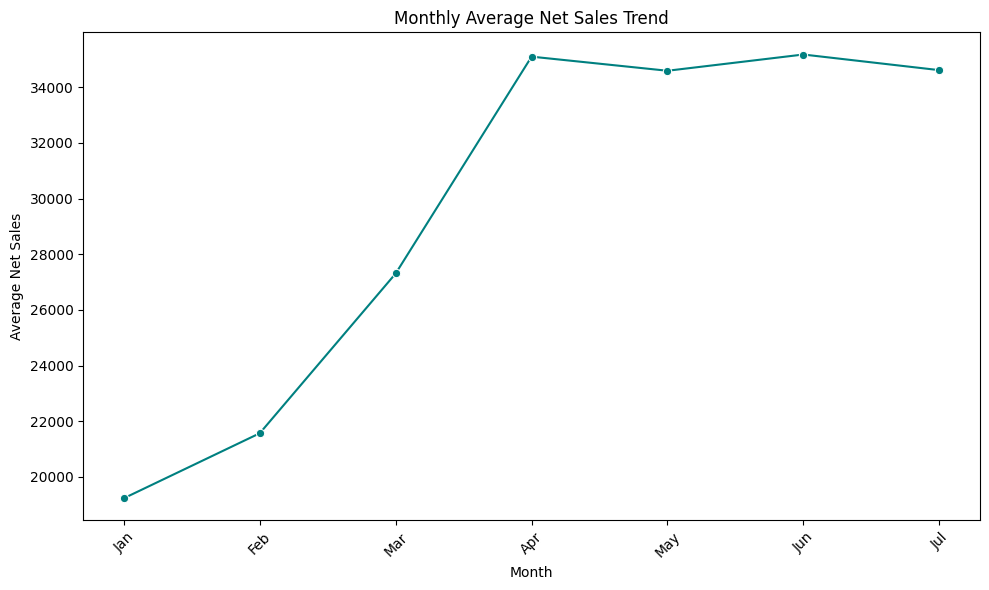

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Seaborn Visualizations ---

# 1. Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_ / sum(model.feature_importances_)
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Feature Importance for Net Sales Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 2. Actual vs. Predicted Sales Plot
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}).sample(2505, random_state=42)  # Sample for clarity
max_value = max(actual_vs_predicted['Actual'].max(), actual_vs_predicted['Predicted'].max())

plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=actual_vs_predicted, color='blue', alpha=0.6)
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='Ideal Line')
plt.title('Actual vs Predicted Net Sales')
plt.xlabel('Actual Net Sales')
plt.ylabel('Predicted Net Sales')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Monthly Sales Trend Plot
monthly_sales = data.groupby('Month_Number')['Net_Sales'].mean().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales['Month_Name'] = monthly_sales['Month_Number'].map(lambda x: month_names[x-1])

plt.figure(figsize=(10, 6))
sns.lineplot(x='Month_Name', y='Net_Sales', data=monthly_sales, marker='o', color='teal')
plt.title('Monthly Average Net Sales Trend')
plt.xlabel('Month')
plt.ylabel('Average Net Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np

# Calculate absolute error
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Absolute_Error': np.abs(y_test - predictions),
    'Percentage_Error': np.abs((y_test - predictions) / y_test) * 100  # Avoid division by zero
})

# Option 1: Filter by absolute error threshold (e.g., errors > 1000)
threshold = 1000  # Adjust based on your data scale
large_deviations = errors[errors['Absolute_Error'] > threshold]
print("\nData points with Absolute Error >", threshold)
print(large_deviations.sort_values(by='Absolute_Error', ascending=False))

# Option 2: Filter by top 5% of errors (using percentile)
error_percentile = errors['Absolute_Error'].quantile(0.95)  # Top 5%
large_deviations_percentile = errors[errors['Absolute_Error'] > error_percentile]
print("\nTop 5% Deviated Data Points (Absolute Error >", error_percentile, ")")
print(large_deviations_percentile.sort_values(by='Absolute_Error', ascending=False))

# Optional: Merge with original test data for context
X_test_with_index = X_test.copy()
X_test_with_index['Index'] = X_test.index
large_deviations = large_deviations.merge(X_test_with_index, left_index=True, right_on='Index')
print("\nDeviated Data Points with Features:")
print(large_deviations[['Actual', 'Predicted', 'Absolute_Error', 'Percentage_Error', 'Unit_Price', 'Sales_Qty', 'Month_Number', 'Year']])


Data points with Absolute Error > 1000
          Actual   Predicted  Absolute_Error  Percentage_Error
6157   1244160.0  1359047.14       114887.14          9.234113
7753   1389197.0  1462133.44        72936.44          5.250259
33     1159935.0  1100493.92        59441.08          5.124518
12445   793872.0   838891.52        45019.52          5.670879
9034   1272384.0  1230124.95        42259.05          3.321250
...          ...         ...             ...               ...
4269     51700.0    50610.74         1089.26          2.106886
7983    269800.0   268736.86         1063.14          0.394047
3571     57225.0    58260.14         1035.14          1.808895
5873     42630.0    43650.20         1020.20          2.393150
12036    22525.0    23525.57         1000.57          4.442042

[78 rows x 4 columns]

Top 5% Deviated Data Points (Absolute Error > 598.1919999999999 )
          Actual   Predicted  Absolute_Error  Percentage_Error
6157   1244160.0  1359047.14       114887.14       

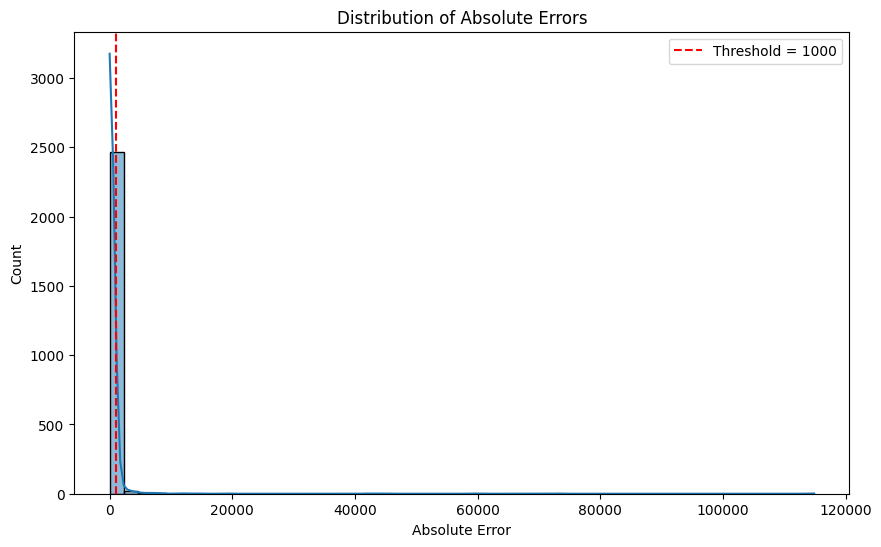

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(errors['Absolute_Error'], bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.legend()
plt.show()

In [12]:
import numpy as np

# Calculate absolute error (assumes errors DataFrame from previous code)
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Absolute_Error': np.abs(y_test - predictions)
})

# Define standard limit (e.g., 10% of mean Net_Sales)
mean_sales = y_test.mean()
standard_limit = 0.1 * mean_sales  # Adjust percentage as needed

# Count values within standard limit
within_limit = errors[errors['Absolute_Error'] <= standard_limit]
num_within_limit = len(within_limit)
percentage_within_limit = (num_within_limit / len(errors)) * 100

print(f"Number of values within standard limit (error <= {standard_limit:.2f}): {num_within_limit}")
print(f"Percentage within limit: {percentage_within_limit:.2f}%")

Number of values within standard limit (error <= 2998.30): 2473
Percentage within limit: 98.72%
